In [ ]:
# Create tickers.txt with some sample tickers
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NFLX", "NVDA", "JPM", "DIS"]

with open("tickers.txt", "w") as f:
    for t in tickers:
        f.write(t + "\n")

print("tickers.txt created with", len(tickers), "tickers")



tickers.txt created with 10 tickers


In [ ]:
"""
DQN-based algorithmic trading project (single model for many companies)

Files and usage:
 - dqn_algorithmic_trading.py  (this file)
 - tickers.txt                 (one ticker per line, up to 500 tickers)

Install dependencies:
 pip install yfinance pandas numpy scikit-learn torch matplotlib tqdm

How it works (short):
 - Downloads OHLCV from yfinance for tickers in tickers.txt
 - Computes features (returns, moving averages, volatility, RSI)
 - Builds an environment per (ticker, time window)
 - Trains a single DQN model with a learnable company embedding so that the
   same network can act on any ticker.

Notes & simplifications:
 - Discrete action space: 0=hold, 1=buy (long 1 share), 2=sell (close position / go to cash)
 - Position is either 0 (no position) or 1 (long 1 share). Shorting not allowed.
 - We train with episodes sampled across tickers and time; this promotes generalization.
 - This is a research / educational baseline. For deployment, add risk controls, slippage, fees, and better reward shaping.

"""

import os
import random
import math
from collections import deque, namedtuple

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from tqdm import trange, tqdm

# ---------- Config ----------
DATA_DIR = 'data'            # where CSVs will be stored
TICKERS_FILE = 'tickers.txt' # file with tickers (one per line)
START_DATE = '2015-01-01'
END_DATE = '2024-12-31'

WINDOW_SIZE = 30   # number of past days used as state
FEATURES = ['open','high','low','close','volume']
EMB_SIZE = 16      # company embedding size
BATCH_SIZE = 64
GAMMA = 0.99
LR = 1e-4
MEMORY_CAPACITY = 200000
TARGET_UPDATE = 1000
TRAIN_STEPS = 200000
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 80000
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- Utilities ----------
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))


def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)


# ---------- Data preparation ----------
class MarketData:
    """Download and prepare features for tickers listed in tickers.txt"""

    def __init__(self, tickers_file=TICKERS_FILE, data_dir=DATA_DIR,
                 start=START_DATE, end=END_DATE):
        self.tickers_file = tickers_file
        self.data_dir = data_dir
        self.start = start
        self.end = end
        ensure_dir(self.data_dir)
        self.tickers = self._read_tickers()
        self.scalers = {}

    def _read_tickers(self):
        if not os.path.exists(self.tickers_file):
            raise FileNotFoundError(f"{self.tickers_file} not found. Put tickers (one per line) in it.")
        with open(self.tickers_file, 'r') as f:
            tickers = [t.strip().upper() for t in f.readlines() if t.strip()]
        return tickers

    def download_all(self):
        for t in tqdm(self.tickers, desc='Downloading'):
            path = os.path.join(self.data_dir, f'{t}.csv')
            if os.path.exists(path):
                continue
            df = yf.download(t, start=self.start, end=self.end, progress=False)
            if df.empty:
                print('Warning: empty data for', t)
                continue
            df.to_csv(path)

    def load_df(self, ticker):
        path = os.path.join(self.data_dir, f'{ticker}.csv')
        if not os.path.exists(path):
            raise FileNotFoundError(path)
        df = pd.read_csv(path, index_col=0, parse_dates=True)
        df = df.dropna()
        return df

    def compute_features(self, df):
        # Basic features: returns, moving averages, volatility, RSI
        df = df.copy()

        # Ensure numeric columns
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df = df.dropna(subset=['Close', 'Volume'])
        df = df.fillna(method='bfill').fillna(method='ffill')

        df['ret'] = df['Close'].pct_change().fillna(0)
        df['log_ret'] = np.log(df['Close']).diff().fillna(0)
        df['ma5'] = df['Close'].rolling(window=5).mean().fillna(method='bfill')
        df['ma10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
        df['std5'] = df['Close'].rolling(window=5).std().fillna(0)
        df['vol'] = df['Volume']

        # RSI (14)
        delta = df['Close'].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        roll_up = up.rolling(14).mean()
        roll_down = down.rolling(14).mean()
        rs = roll_up / (roll_down + 1e-6)
        df['rsi'] = 100.0 - (100.0 / (1.0 + rs))

        df = df.fillna(method='bfill').fillna(0)
        feature_cols = ['Close','ret','log_ret','ma5','ma10','std5','vol','rsi']
        return df[feature_cols]


    def fit_scaler(self):
        # Fit a StandardScaler per ticker (we will save mean/std to normalize when sampling)
        for t in tqdm(self.tickers, desc='Fitting scalers'):
            try:
                df = self.load_df(t)
            except FileNotFoundError:
                continue
            feat = self.compute_features(df)
            scaler = StandardScaler()
            scaler.fit(feat.values)
            self.scalers[t] = scaler

    def save_scalers(self, path='scalers.npy'):
        np.save(path, self.scalers)

    def load_scalers(self, path='scalers.npy'):
        self.scalers = np.load(path, allow_pickle=True).item()


# ---------- Environment ----------
class TradingEnv:
    """Simple single-asset trading env. Position is 0 or 1 (long 1 share).
    State: WINDOW_SIZE days of features + position (0/1) + company index
    Actions: 0 hold, 1 buy, 2 sell
    """

    def __init__(self, features_df, scaler, ticker_idx, window_size=WINDOW_SIZE, initial_cash=10000):
        self.df = features_df.reset_index(drop=True)
        self.scaler = scaler
        self.window = window_size
        self.ticker_idx = ticker_idx
        self.initial_cash = initial_cash
        self.reset_episode()

    def reset_episode(self, start_idx=None):
        max_start = len(self.df) - self.window - 2
        if max_start <= 0:
            raise ValueError('Data too short')
        if start_idx is None:
            self.pos = random.randint(0, max_start)
        else:
            self.pos = start_idx
        self.current_step = self.pos + self.window
        self.end_step = len(self.df) - 1
        self.cash = self.initial_cash
        self.shares = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        slice_df = self.df.iloc[self.current_step - self.window:self.current_step]
        X = slice_df.values
        X = self.scaler.transform(X)
        # flatten
        state = X.flatten()
        # append position flag
        state = np.concatenate([state, np.array([self.shares])])
        # append ticker index as integer (we will convert to tensor and use embedding)
        return {'obs': state.astype(np.float32), 'ticker_idx': self.ticker_idx}

    def step(self, action):
        # action: 0 hold,1 buy,2 sell
        price = float(self.df.iloc[self.current_step]['Close'])
        reward = 0.0
        # execute
        if action == 1:  # buy
            if self.shares == 0:
                # buy 1 share with available cash (ignore fractional or partial)
                if self.cash >= price:
                    self.shares = 1
                    self.cash -= price
        elif action == 2:  # sell
            if self.shares == 1:
                self.shares = 0
                self.cash += price
        # next step
        prev_val = self.cash + self.shares * price
        self.current_step += 1
        new_price = float(self.df.iloc[self.current_step]['Close'])
        new_val = self.cash + self.shares * new_price
        reward = new_val - prev_val  # profit change
        # small shaping to encourage activity? we'll leave as raw P&L
        if self.current_step >= self.end_step:
            self.done = True
        next_state = self._get_state()
        return next_state, reward, self.done, {}


# ---------- Replay Buffer ----------
class ReplayBuffer:
    def __init__(self, capacity=MEMORY_CAPACITY):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)


# ---------- Model ----------
class DQNModel(nn.Module):
    def __init__(self, state_dim, n_tickers, emb_size=EMB_SIZE, n_actions=3):
        super().__init__()
        self.emb = nn.Embedding(n_tickers, emb_size)
        hidden = 256
        self.net = nn.Sequential(
            nn.Linear(state_dim + emb_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions)
        )

    def forward(self, obs, ticker_idx):
        # obs: (batch, state_dim)
        emb = self.emb(ticker_idx)  # batch x emb_size
        x = torch.cat([obs, emb], dim=1)
        return self.net(x)


# ---------- Helper for batching states ----------
def stack_states(states):
    # states: tuple of dicts
    obs = np.stack([s['obs'] for s in states])
    ticker_idx = np.array([s['ticker_idx'] for s in states], dtype=np.int64)
    return obs, ticker_idx


# ---------- Training loop ----------

def train():
    md = MarketData()
    print('Tickers found:', len(md.tickers))
    md.download_all()
    md.fit_scaler()
    # build list of prepared data per ticker (features + scaler)
    data_store = []
    valid_tickers = []
    for i, t in enumerate(md.tickers):
        try:
            df = md.load_df(t)
        except FileNotFoundError:
            continue
        feat = md.compute_features(df)
        if len(feat) < WINDOW_SIZE + 2:
            continue
        data_store.append((t, feat))
        valid_tickers.append(t)
    n_tickers = len(valid_tickers)
    print('Usable tickers:', n_tickers)
    # create scalers mapping for these tickers
    scalers = {t: md.scalers[t] for t in valid_tickers}
    # compute state dim
    sample_x = data_store[0][1].iloc[:WINDOW_SIZE].values
    state_dim = sample_x.size + 1  # flattened window + shares flag

    # create models
    policy_net = DQNModel(state_dim, n_tickers).to(DEVICE)
    target_net = DQNModel(state_dim, n_tickers).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayBuffer()

    steps_done = 0

    def select_action(state_dict, eps):
        obs = torch.from_numpy(state_dict['obs']).float().unsqueeze(0).to(DEVICE)
        tidx = torch.tensor([state_dict['ticker_idx']], dtype=torch.long).to(DEVICE)
        sample = random.random()
        if sample > eps:
            with torch.no_grad():
                q = policy_net(obs, tidx)
                action = q.argmax(dim=1).item()
                return action
        else:
            return random.randrange(3)

    # Pre-fill replay buffer with random policy for stability
    print('Prefilling replay buffer...')
    while len(memory) < 20000:
        # sample random ticker and random start
        tidx = random.randrange(n_tickers)
        t, feat = data_store[tidx]
        env = TradingEnv(feat, scalers[t], ticker_idx=tidx)
        s = env.reset_episode()
        done = False
        while not done and len(memory) < 20000:
            a = random.randrange(3)
            s2, r, done, _ = env.step(a)
            memory.push(s, a, r, s2, done)
            s = s2

    print('Starting training...')
    pbar = trange(TRAIN_STEPS)
    for step in pbar:
        # epsilon schedule
        eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1

        # sample an episode fragment
        tidx = random.randrange(n_tickers)
        t, feat = data_store[tidx]
        env = TradingEnv(feat, scalers[t], ticker_idx=tidx)
        s = env.reset_episode()
        a = select_action(s, eps)
        s2, r, done, _ = env.step(a)
        memory.push(s, a, r, s2, done)

        # training step
        if len(memory) >= BATCH_SIZE:
            trans = memory.sample(BATCH_SIZE)
            obs_batch, tidx_batch = stack_states(trans.state)
            obs_batch = torch.from_numpy(obs_batch).float().to(DEVICE)
            tidx_batch = torch.from_numpy(tidx_batch).long().to(DEVICE)
            action_batch = torch.tensor(trans.action, dtype=torch.long).unsqueeze(1).to(DEVICE)
            reward_batch = torch.tensor(trans.reward, dtype=torch.float32).unsqueeze(1).to(DEVICE)
            non_final_mask = torch.tensor([not d for d in trans.done], dtype=torch.bool).to(DEVICE)
            non_final_next = [s for s, d in zip(trans.next_state, trans.done) if not d]

            # Q values
            q_values = policy_net(obs_batch, tidx_batch).gather(1, action_batch)

            # next state values
            next_values = torch.zeros(BATCH_SIZE, 1, device=DEVICE)
            if non_final_next:
                next_obs, next_tidx = stack_states(non_final_next)
                next_obs = torch.from_numpy(next_obs).float().to(DEVICE)
                next_tidx = torch.from_numpy(next_tidx).long().to(DEVICE)
                next_q = target_net(next_obs, next_tidx)
                next_values[non_final_mask] = next_q.max(1)[0].detach().unsqueeze(1)

            expected_q = reward_batch + (GAMMA * next_values)
            loss = nn.MSELoss()(q_values, expected_q)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
            optimizer.step()

        # update target
        if step % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # logging
        if step % 500 == 0:
            pbar.set_postfix({'step': step, 'eps': eps})

    # save model
    torch.save({'policy_state_dict': policy_net.state_dict(),
                'scalers': scalers,
                'tickers': valid_tickers}, 'dqn_trading_checkpoint.pth')
    print('Training complete. Model saved to dqn_trading_checkpoint.pth')


# ---------- Evaluation helper ----------
def evaluate(model_path='dqn_trading_checkpoint.pth', n_episodes=20):
    ckpt = torch.load(model_path, map_location=DEVICE)
    scalers = ckpt['scalers']
    tickers = ckpt['tickers']
    md = MarketData()
    data_store = []
    for t in tickers:
        df = md.load_df(t)
        feat = md.compute_features(df)
        data_store.append((t, feat))
    n_tickers = len(tickers)
    sample_x = data_store[0][1].iloc[:WINDOW_SIZE].values
    state_dim = sample_x.size + 1
    policy_net = DQNModel(state_dim, n_tickers).to(DEVICE)
    policy_net.load_state_dict(ckpt['policy_state_dict'])
    policy_net.eval()

    results = {}
    for i, (t, feat) in enumerate(data_store):
        total_returns = []
        for _ in range(n_episodes):
            env = TradingEnv(feat, scalers[t], ticker_idx=i)
            s = env.reset_episode()
            done = False
            while not done:
                obs = torch.from_numpy(s['obs']).float().unsqueeze(0).to(DEVICE)
                tidx = torch.tensor([s['ticker_idx']], dtype=torch.long).to(DEVICE)
                with torch.no_grad():
                    q = policy_net(obs, tidx)
                    a = q.argmax(dim=1).item()
                s, r, done, _ = env.step(a)
            final_val = env.cash + env.shares * float(env.df.iloc[env.current_step]['Close'])
            total_returns.append(final_val / env.initial_cash - 1.0)
        results[t] = np.mean(total_returns)
    # print average return across tickers
    avg = np.mean(list(results.values()))
    print('Average % return across tickers (per-episode mean):', avg * 100)
    return results


# ---------- Main ----------
if __name__ == '__main__':
    import argparse, sys
    parser = argparse.ArgumentParser()
    parser.add_argument('--mode', choices=['train', 'eval'], default='train')
    # ignore unknown args that Colab/Jupyter inject
    args, _ = parser.parse_known_args(sys.argv[1:])

    if args.mode == 'train':
        train()
    else:
        evaluate()

Tickers found: 10


Downloading:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipython-input-254798472.py:98: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=self.start, end=self.end, progress=False)
Downloading:  10%|█         | 1/10 [00:00<00:04,  1.84it/s]/tmp/ipython-input-254798472.py:98: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=self.start, end=self.end, progress=False)
Downloading:  20%|██        | 2/10 [00:00<00:03,  2.55it/s]/tmp/ipython-input-254798472.py:98: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=self.start, end=self.end, progress=False)
Downloading:  30%|███       | 3/10 [00:01<00:02,  2.84it/s]/tmp/ipython-input-254798472.py:98: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=self.start, end=self.end, progress=False)
Downloading:  40%|████      | 4/10 [

Usable tickers: 10
Prefilling replay buffer...
Starting training...


100%|██████████| 200000/200000 [30:05<00:00, 110.80it/s, step=2e+5, eps=0.128]


Training complete. Model saved to dqn_trading_checkpoint.pth


/tmp/ipython-input-254798472.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/tmp/ipython-input-254798472.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-254798472.py:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(window=5).mean().fillna(method='bfill')
/tmp/ipython-input-254798472.py:127: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
/tmp

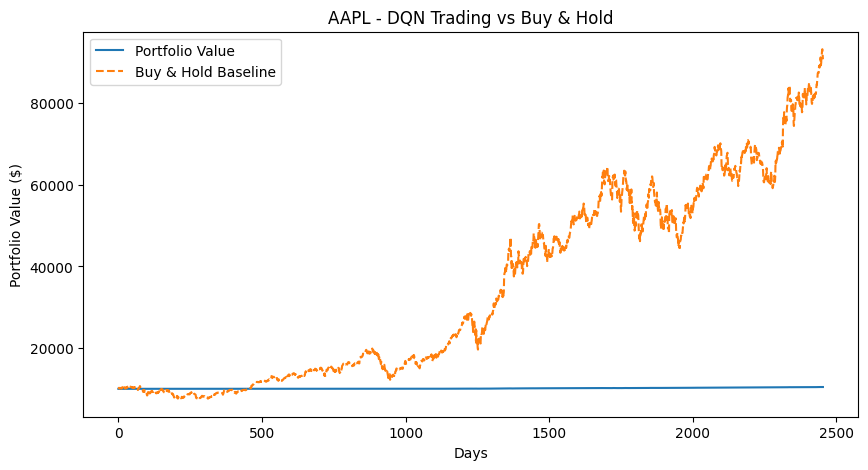

✅ AAPL: Final portfolio value = $10443.01 (4.43% return)


/tmp/ipython-input-254798472.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/tmp/ipython-input-254798472.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-254798472.py:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(window=5).mean().fillna(method='bfill')
/tmp/ipython-input-254798472.py:127: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
/tmp

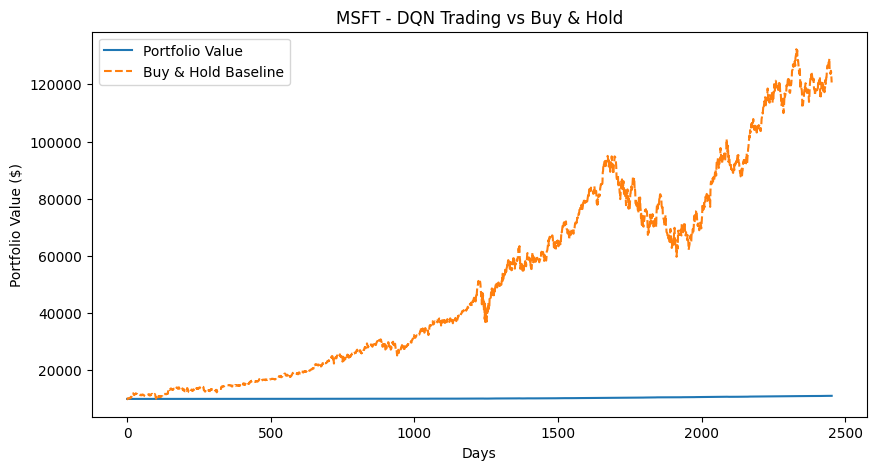

✅ MSFT: Final portfolio value = $11082.01 (10.82% return)


/tmp/ipython-input-254798472.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/tmp/ipython-input-254798472.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-254798472.py:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(window=5).mean().fillna(method='bfill')
/tmp/ipython-input-254798472.py:127: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
/tmp

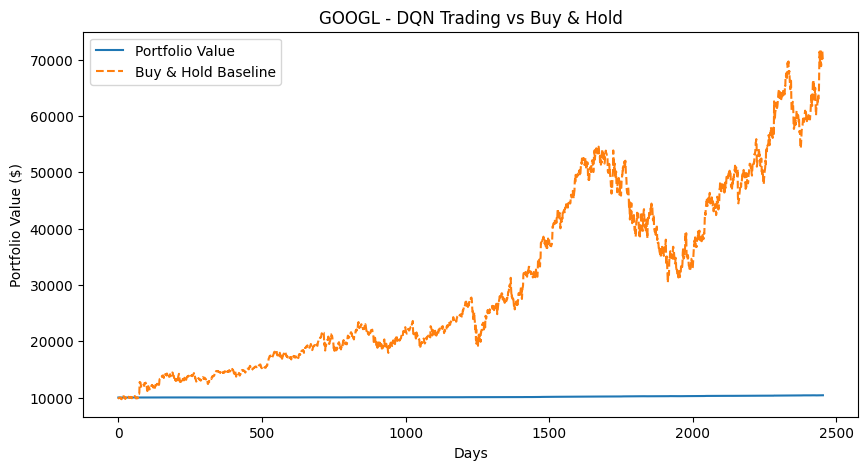

✅ GOOGL: Final portfolio value = $10398.20 (3.98% return)


/tmp/ipython-input-254798472.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/tmp/ipython-input-254798472.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-254798472.py:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(window=5).mean().fillna(method='bfill')
/tmp/ipython-input-254798472.py:127: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
/tmp

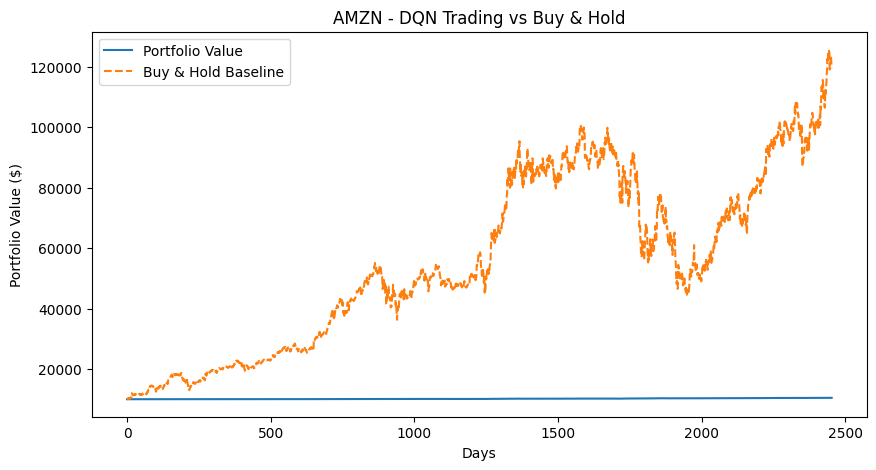

✅ AMZN: Final portfolio value = $10462.61 (4.63% return)


/tmp/ipython-input-254798472.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/tmp/ipython-input-254798472.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-254798472.py:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(window=5).mean().fillna(method='bfill')
/tmp/ipython-input-254798472.py:127: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
/tmp

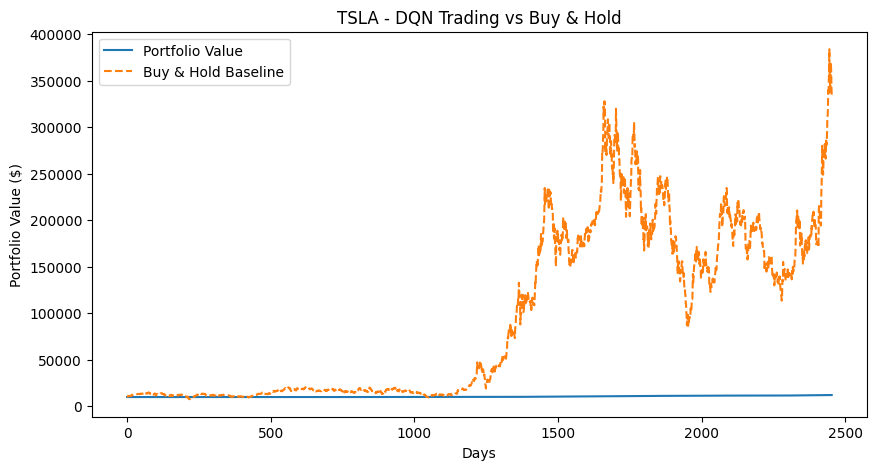

✅ TSLA: Final portfolio value = $12149.61 (21.50% return)


/tmp/ipython-input-254798472.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/tmp/ipython-input-254798472.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-254798472.py:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(window=5).mean().fillna(method='bfill')
/tmp/ipython-input-254798472.py:127: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
/tmp

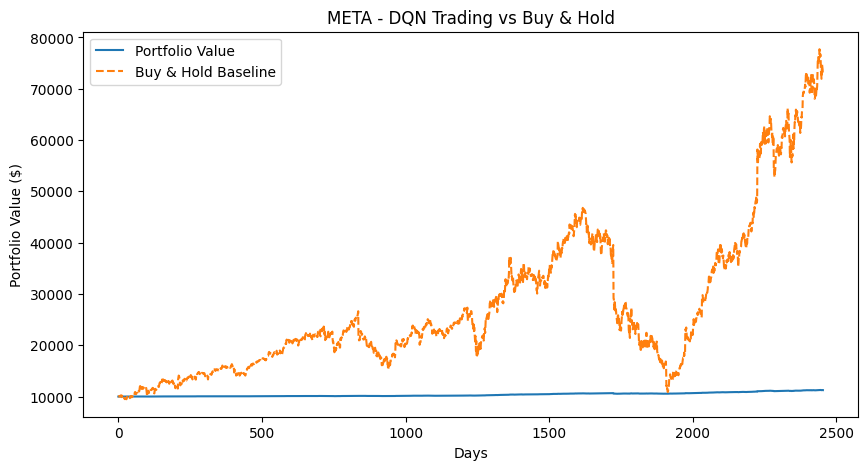

✅ META: Final portfolio value = $11256.46 (12.56% return)


/tmp/ipython-input-254798472.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/tmp/ipython-input-254798472.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-254798472.py:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(window=5).mean().fillna(method='bfill')
/tmp/ipython-input-254798472.py:127: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
/tmp

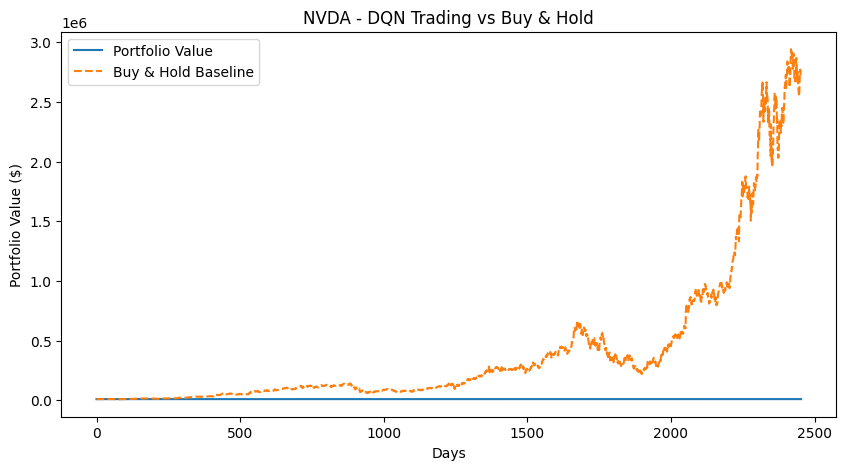

✅ NVDA: Final portfolio value = $10229.00 (2.29% return)


/tmp/ipython-input-254798472.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/tmp/ipython-input-254798472.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-254798472.py:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(window=5).mean().fillna(method='bfill')
/tmp/ipython-input-254798472.py:127: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
/tmp

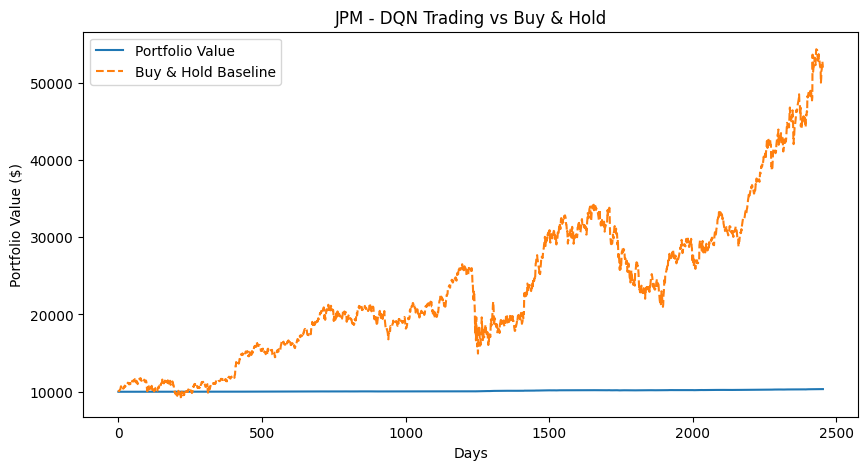

✅ JPM: Final portfolio value = $10343.45 (3.43% return)


/tmp/ipython-input-254798472.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/tmp/ipython-input-254798472.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-254798472.py:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(window=5).mean().fillna(method='bfill')
/tmp/ipython-input-254798472.py:127: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
/tmp

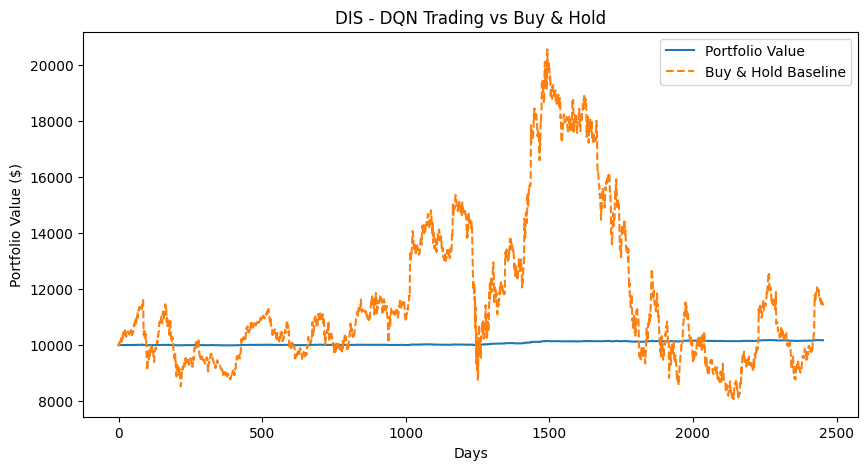

✅ DIS: Final portfolio value = $10174.17 (1.74% return)


/tmp/ipython-input-254798472.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/tmp/ipython-input-254798472.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-254798472.py:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(window=5).mean().fillna(method='bfill')
/tmp/ipython-input-254798472.py:127: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(window=10).mean().fillna(method='bfill')
/tmp

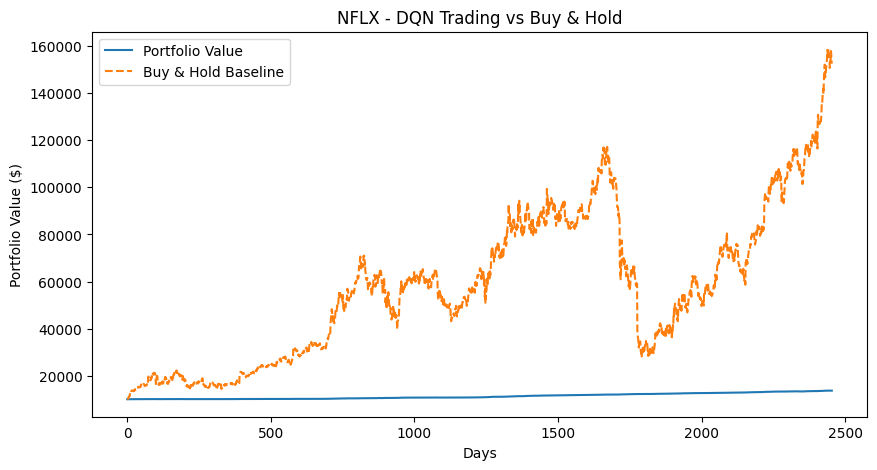

✅ NFLX: Final portfolio value = $13642.21 (36.42% return)

--- SUMMARY ---
AAPL: 4.43%
MSFT: 10.82%
GOOGL: 3.98%
AMZN: 4.63%
TSLA: 21.50%
META: 12.56%
NVDA: 2.29%
JPM: 3.43%
DIS: 1.74%
NFLX: 36.42%

Average return across all: 10.18%


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import yfinance as yf

def test_single_ticker(model_path, ticker, start='2022-01-01', end='2024-12-31'):
    """Run the trained model on one ticker and show performance."""
    ckpt = torch.load(model_path, weights_only=False, map_location=DEVICE)
    scalers = ckpt['scalers']
    tickers = ckpt['tickers']
    n_tickers = len(tickers)

    # Check if ticker was seen during training
    if ticker not in tickers:
        print(f"⚠️ {ticker} not seen during training — downloading new data.")
        df = yf.download(ticker, start=start, end=end, progress=False)
        md = MarketData()
        feat = md.compute_features(df)
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaler.fit(feat.values)
        scalers[ticker] = scaler
        tickers.append(ticker)
        ticker_idx = len(tickers) - 1
    else:
        ticker_idx = tickers.index(ticker)
        md = MarketData()
        df = md.load_df(ticker)
        feat = md.compute_features(df)

    # Prepare model
    sample_x = feat.iloc[:WINDOW_SIZE].values
    state_dim = sample_x.size + 1
    policy_net = DQNModel(state_dim, len(tickers)).to(DEVICE)
    policy_net.load_state_dict(ckpt['policy_state_dict'])
    policy_net.eval()

    # Simulate environment
    env = TradingEnv(feat, scalers[ticker], ticker_idx=ticker_idx)
    s = env.reset_episode(start_idx=WINDOW_SIZE)
    done = False
    portfolio_values = []
    prices = []

    while not done:
        obs = torch.from_numpy(s['obs']).float().unsqueeze(0).to(DEVICE)
        tidx = torch.tensor([s['ticker_idx']], dtype=torch.long).to(DEVICE)
        with torch.no_grad():
            q = policy_net(obs, tidx)
            a = q.argmax(dim=1).item()
        s, r, done, _ = env.step(a)
        val = env.cash + env.shares * float(env.df.iloc[env.current_step]['Close'])
        portfolio_values.append(val)
        prices.append(float(env.df.iloc[env.current_step]['Close']))

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_values, label="Portfolio Value")
    plt.plot(np.array(prices) / prices[0] * env.initial_cash, label="Buy & Hold Baseline", linestyle='--')
    plt.title(f"{ticker} - DQN Trading vs Buy & Hold")
    plt.xlabel("Days")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.show()

    final_val = portfolio_values[-1]
    total_return = (final_val / env.initial_cash - 1) * 100
    print(f"{ticker}: Final portfolio value = ${final_val:.2f} ({total_return:.2f}% return)")
    return total_return


def test_multiple_tickers(model_path='dqn_trading_checkpoint.pth'):
    """Test model across multiple tickers and compare returns."""
    test_tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "JPM", "DIS", "NFLX"]
    results = {}
    for t in test_tickers:
        try:
            results[t] = test_single_ticker(model_path, t)
        except Exception as e:
            print(f"{t} failed: {e}")

    # Summary
    print("\n--- SUMMARY ---")
    for k, v in results.items():
        print(f"{k}: {v:.2f}%")
    print(f"\nAverage return across all: {np.mean(list(results.values())):.2f}%")

if __name__ == "__main__":
    # Test all tickers
    test_multiple_tickers("dqn_trading_checkpoint.pth")